In [ ]:
import tensorflow as tf
import numpy as np
import os
import tensorflow_datasets as tfds
from wandb.keras import WandbCallback
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data,info=tfds.load(name="malaria",shuffle_files=True,with_info=True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteZO43EG/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
TRAIN_RATIO=0.5
TEST_RATIO=0.1
VAL_RATIO=0.1
data=data["train"]
DATA_SIZE=len(data)
train_data=data.take(int(TRAIN_RATIO*DATA_SIZE))
test_val_data=data.skip(int(TRAIN_RATIO*DATA_SIZE))
test_data=test_val_data.take(int(TEST_RATIO*DATA_SIZE))
val_data=test_val_data.skip(int(TRAIN_RATIO*DATA_SIZE)-int(TEST_RATIO*DATA_SIZE))
val_data=val_data.take(int(VAL_RATIO*DATA_SIZE))

In [ ]:
IMAGE_SIZE=(224,224)
@tf.function
def resize_rescaling(img,lab):
  return tf.image.resize(img,IMAGE_SIZE)/255.,lab

In [ ]:
train_data_new=train_data.map(resize_rescaling).batch(16).prefetch(tf.data.AUTOTUNE)
val_data_new=val_data.map(resize_rescaling).batch(16).prefetch(tf.data.AUTOTUNE)

In [ ]:
### to add dropout layers and to initialize L2 regluarlize
IMAGE_SIZE=(224,224)
dropout_rate=0.2
model=tf.keras.Sequential(
    [
        tf.keras.Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3)),

        tf.keras.layers.Conv2D(8,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(rate=dropout_rate),

        tf.keras.layers.Conv2D(16,3,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(8,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid"),
    ]

    )

In [ ]:
# ### install and login wandb
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=1716541ca62aae78911637c5c75d684dc154ab1fd227d886f6b51ea8b8ce8960
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or pr

In [ ]:
## to inialize projet
wandb.init(project="malaria-detection",entity="sathishmahi398")

In [ ]:
wandb.config={ "LEARNING_RATE":0.01,
    "DROP_OUT_RATE":0.2,
    "IMAGE_SIZE_HEIGHT":224,
    "IMAGE_SIZE_WIDTH":224,
    "REGULARIZATION_RATE":0.1,
    "EPOCHS":2
}


In [ ]:
CONFIGURATION={ "LEARNING_RATE":0.01,
    "DROP_OUT_RATE":0.2,
    "IMAGE_SIZE_HEIGHT":224,
    "IMAGE_SIZE_WIDTH":224,
    "REGULARIZATION_RATE":0.1,
    "EPOCHS":2
}


In [ ]:
# wandb.run
metrics=[
    tf.keras.metrics.TrueNegatives(name="tn"),tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TruePositives(name="tp"),tf.keras.metrics.FalseNegatives(name="fn"),
]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
,loss=tf.keras.losses.BinaryCrossentropy(),metrics=metrics)

In [ ]:
# for img,lab in test_data_new.take(1):
#   print(img.numpy())
#   print(lab.numpy())
test_data_new=test_data.map(resize_rescaling)

In [ ]:
[i for i in tf.constant([[1,2,3,2,2,]])]

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>]

In [ ]:
[i for i in tf.squeeze( tf.constant([[1],[2]]),axis=1)]

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>]

In [ ]:

class CustomImageWanDBCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    lab_li,img_li=[],[]
    for img,lab in test_data_new.take(10):
      lab_li.append(lab.numpy())
      img_li.append(img.numpy())
    pre=model.predict(np.array(img_li))
    pre_li=list(tf.squeeze(pre,axis=1).numpy())
    y_pre=list(map(lambda p: 1 if p>0.5 else 0,pre_li))
    sns.heatmap(confusion_matrix(lab_li,y_pre),annot=True)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    file_name="confusion.png"
    plt.savefig(file_name)
    im_arr=plt.imread(file_name)
    image=wandb.Image(im_arr,caption=f"confusion_matrix image for {epoch}")
    wandb.log(
        {
            "confusion-matrix-image":image
        }
    )

In [ ]:
class CustomWanDBCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    lab_li,img_li=[],[]
    for img,lab in test_data_new.take(10):
      lab_li.append(lab.numpy())
      img_li.append(img.numpy())
    pre=model.predict(np.array(img_li))
    # print(pre.shape)

    y_pre=list(map(lambda p: [1,0] if p>0.5 else [0,1],list(tf.squeeze(pre,axis=1).numpy())))
    print(y_pre)
    print(lab_li)



    wandb.log(
        {
            "confusion_matrix":wandb.plot.confusion_matrix(y_true=np.array(lab_li),class_names=["malaria","no_malaria"],probs=np.array(y_pre))
        }
    )

In [ ]:
list(map(lambda a:[a,1],list(tf.constant([12,1,1]).numpy())))

[[12, 1], [1, 1], [1, 1]]

50/50 [==============================] - 28s 568ms/step - loss: 0.7013 - tn: 0.0000e+00 - fp: 393.0000 - tp: 407.0000 - fn: 0.0000e+00 - val_loss: 0.6984 - val_tn: 0.0000e+00 - val_fp: 159.0000 - val_tp: 161.0000 - val_fn: 0.0000e+00


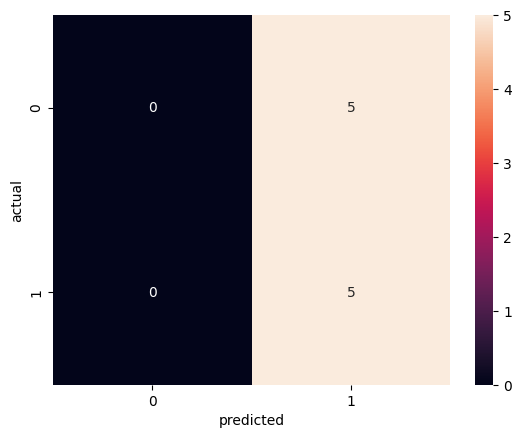

In [ ]:
model.fit(train_data_new.take(50),validation_data=val_data_new.take(20),epochs=1,
          callbacks=[
              # WandbCallback(validation_data=val_data_new.take(20),labels=["malaria","no_malaria"],data_type="image")
              CustomImageWanDBCallback()
          ])

In [ ]:
wandb.finish()

### hyper parameter tuning using wandb

In [ ]:
sweep_config={
    "name":"malaria-prediction-sweep-1",
    "method":"random",
    "parameters":{
        "EPOCHS":{
            "values":[1,2,3]
        },
        "IMAGE_SIZE_HEIGHT":{
            "value":224
        },
        "IMAGE_SIZE_WIDTH":{
            "value":224
        },
        "LEARNING_RATE":{
            "distribution":"uniform",
            "min":0.001,
            "max":0.01
        },
        "DROP_OUT_RATE":{
            "distribution":"uniform",
            "min":0.1,
            "max":0.3
        },
        "REGULARIZATION_RATE":{
            "distribution":"uniform",
            "min":0.1,
            "max":0.3
        }
    },
    "metric":{
        "name":"accuracy",
        "goal":"maximize"
    }
}

sweep_id=wandb.sweep(sweep_config)

Create sweep with ID: y61d3niy
Sweep URL: https://wandb.ai/sathishmahi398/uncategorized/sweeps/y61d3niy


In [ ]:
def return_model(config):

  model=tf.keras.Sequential(
    [
        tf.keras.Input((config.IMAGE_SIZE_HEIGHT,config.IMAGE_SIZE_WIDTH,3)),

        tf.keras.layers.Conv2D(8,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(config.REGULARIZATION_RATE)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(rate=config.DROP_OUT_RATE),

        tf.keras.layers.Conv2D(16,3,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(config.REGULARIZATION_RATE)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dropout(rate=config.DROP_OUT_RATE),
        tf.keras.layers.Dense(8,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid"),
    ]

    )
  return model

In [ ]:
def train():
  with wandb.init(project="malaria-detection",entity="sathishmahi398") as run:

    config=wandb.config
    model=return_model(config)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE))
    model.fit(train_data_new.take(50),epochs=config.EPOCHS)

s=5
wandb.agent(sweep_id,train,count=s)

wandb: Agent Starting Run: mu25d0nj with config:
wandb: 	DROP_OUT_RATE: 0.14110482506228297
wandb: 	EPOCHS: 2
wandb: 	IMAGE_SIZE_HEIGHT: 224
wandb: 	IMAGE_SIZE_WIDTH: 224
wandb: 	LEARNING_RATE: 0.0012146383923056056
wandb: 	REGULARIZATION_RATE: 0.10838228935568038
wandb: Currently logged in as: sathishmahi398. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/2
50/50 [==============================] - 19s 340ms/step - loss: 2.5489 - accuracy: 0.4938
Epoch 2/2
50/50 [==============================] - 18s 354ms/step - loss: 1.3736 - accuracy: 0.5138


wandb: Agent Starting Run: ygzzv770 with config:
wandb: 	DROP_OUT_RATE: 0.23118705752699
wandb: 	EPOCHS: 3
wandb: 	IMAGE_SIZE_HEIGHT: 224
wandb: 	IMAGE_SIZE_WIDTH: 224
wandb: 	LEARNING_RATE: 0.009960769469970654
wandb: 	REGULARIZATION_RATE: 0.11518170091084128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/3
50/50 [==============================] - 18s 342ms/step - loss: 1.4268 - accuracy: 0.5038
Epoch 2/3
50/50 [==============================] - 16s 312ms/step - loss: 0.7680 - accuracy: 0.4925
Epoch 3/3
50/50 [==============================] - 16s 317ms/step - loss: 0.7079 - accuracy: 0.5025


wandb: Agent Starting Run: 5d2dt5ru with config:
wandb: 	DROP_OUT_RATE: 0.19147240085236425
wandb: 	EPOCHS: 3
wandb: 	IMAGE_SIZE_HEIGHT: 224
wandb: 	IMAGE_SIZE_WIDTH: 224
wandb: 	LEARNING_RATE: 0.0035957465585498014
wandb: 	REGULARIZATION_RATE: 0.28797585820323013
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/3
50/50 [==============================] - 17s 325ms/step - loss: 2.8030 - accuracy: 0.4988
Epoch 2/3
50/50 [==============================] - 16s 317ms/step - loss: 0.8958 - accuracy: 0.5100
Epoch 3/3
50/50 [==============================] - 16s 314ms/step - loss: 0.7892 - accuracy: 0.5088


wandb: Agent Starting Run: xu83jrgb with config:
wandb: 	DROP_OUT_RATE: 0.2820446848779451
wandb: 	EPOCHS: 3
wandb: 	IMAGE_SIZE_HEIGHT: 224
wandb: 	IMAGE_SIZE_WIDTH: 224
wandb: 	LEARNING_RATE: 0.0015522062444712043
wandb: 	REGULARIZATION_RATE: 0.23214513681961987
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/3
50/50 [==============================] - 18s 340ms/step - loss: 3.8261 - accuracy: 0.4925
Epoch 2/3
50/50 [==============================] - 16s 314ms/step - loss: 1.3278 - accuracy: 0.5075
Epoch 3/3
50/50 [==============================] - 16s 313ms/step - loss: 0.8962 - accuracy: 0.4925


wandb: Agent Starting Run: q3my1rhv with config:
wandb: 	DROP_OUT_RATE: 0.10011941139759024
wandb: 	EPOCHS: 3
wandb: 	IMAGE_SIZE_HEIGHT: 224
wandb: 	IMAGE_SIZE_WIDTH: 224
wandb: 	LEARNING_RATE: 0.002123503022638501
wandb: 	REGULARIZATION_RATE: 0.2936154272266911
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/3
50/50 [==============================] - 18s 325ms/step - loss: 3.6221 - accuracy: 0.5125
Epoch 2/3
50/50 [==============================] - 16s 312ms/step - loss: 0.9738 - accuracy: 0.5250
Epoch 3/3
50/50 [==============================] - 17s 334ms/step - loss: 0.7519 - accuracy: 0.5025


### Data versioning using wandb

In [ ]:
### to save data into npz format

for ind,img_lab in enumerate(data):
  with open(os.path.join("malaria",f"malaria_data_{ind}.npz"),mode="wb") as f:
    np.savez(f,img_lab[0])
  if ind==1500:
    break


In [ ]:
# !rm -rf "malaria"
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [ ]:
# wandb.finish()

def log_original_data(dir_path="malaria"):
  with wandb.init(project="malaria-detection",entity="sathishmahi398") as run:
    original_data=wandb.Artifact("original_datas",type="raw_dataset",
                                 description="this is tensorflow malaria dataset",
                                 metadata={
                                    "no_of_data":"1500",
                                    "no_class":"2"
                                 })
    print(original_data)
    original_data.add_dir(dir_path)
    run.log_artifact(original_data)

In [ ]:
log_original_data()

wandb: Adding directory to artifact (./malaria)... 

Done. 1.3s


In [ ]:
## to load the original data from wandb

# run = wandb.init()
# artifact = run.use_artifact('sathishmahi398/uncategorized/original_datas:v0', type='raw_dataset')

# artifact_dir = artifact.download()

In [ ]:
def load_preprocess_data(preprocessd_data_path="preprocess_data.npz",original_data_path="malaria"):

  all_img=[]
  for ind,file_name in enumerate(os.listdir(original_data_path)):
    file_path=os.path.join(original_data_path,file_name)
    with open(file_path,mode="rb") as f:
      npz_arr=np.load(f)
      img_arr=npz_arr.f.arr_0
      img,_=resize_rescaling(img_arr,None)
      all_img.append(img)
  with wandb.init(project="malaria-detection",entity="sathishmahi398") as run:
    artifact = run.use_artifact('sathishmahi398/malaria-detection/original_datas:v0', type='raw_dataset')
    artifact_dir = artifact.download()
    preprocessd_data=wandb.Artifact(name="preprocessd_data",description="preprocessd_data",type="preprocess_data")
    with preprocessd_data.new_file(preprocessd_data_path,"wb") as f:
      np.savez(f,all_img)
    run.log_artifact(preprocessd_data)

In [ ]:
load_preprocess_data()

wandb: Downloading large artifact original_datas:v0, 77.64MB. 1501 files... 
wandb:   1501 of 1501 files downloaded.  
Done. 0:0:0.9


1501

In [ ]:
# ### to load preprocess data from wandb
# run = wandb.init()
# artifact = run.use_artifact('sathishmahi398/malaria-detection/preprocessd_data:v0', type='preprocess_data')
# artifact_dir = artifact.download()

In [ ]:
# with open("/content/artifacts/preprocessd_data:v0/preprocess_data.npz","rb") as f:
#   npz_file=np.load(f,allow_pickle=True)
#   img_arr=npz_file.f.arr_0

In [ ]:
# img_arr.shape

In [ ]:
def to_read_npz(file_path):
  with open(file_path,"rb") as fi:
    npz_obj=np.load(fi)
    img_arr=npz_obj.f.arr_0
  return img_arr

In [ ]:
# train_i=to_read_npz("/content/artifacts/preprocessd_data:v0/preprocess_data.npz")

In [ ]:
def to_save_file_wandb(run,data_obj,data,file_path):
  with data_obj.new_file(file_path,"wb") as f:
      np.savez(f,data)
  run.log_artifact(data_obj)

In [ ]:
### to load the split data

def load_split_data_data(train_data_path="train.npz",test_data_path="test.npz",val_data_path="val.npz"
                          ,original_data_path="malaria",ratio=(0.8,0.1,0.1)):
  with wandb.init(project="malaria-detection",entity="sathishmahi398") as run:
    artifact = run.use_artifact('sathishmahi398/malaria-detection/preprocessd_data:v0', type='preprocess_data')
    artifact_dir = artifact.download()

    img_arr=to_read_npz(os.path.join(artifact_dir,os.listdir(artifact_dir)[0]))
    train_ratio,test_ratio,val_ratio=ratio

    train_data_wan=img_arr[:int(len(img_arr)*train_ratio)]
    test_data_wan=img_arr[int(len(img_arr)*train_ratio):int(len(img_arr)*test_ratio)]
    val_data_wan=img_arr[int(len(img_arr)*train_ratio)+int(len(img_arr)*test_ratio):]
    # preprocessd_data.add_dir(preprocessd_data_path)
    train_data_arti=wandb.Artifact(name="train_data",description="train_data",type="train_data")
    test_data_arti=wandb.Artifact(name="test_data",description="test_data",type="test_data")
    val_data_arti=wandb.Artifact(name="val_data",description="val_data",type="val_data")
    [to_save_file_wandb(run,obj,data,path) for obj,path,data in zip((train_data_arti,test_data_arti,val_data_arti),
     ("train_data.npz","test_data.npz","val_data.npz"),(train_data_wan,test_data_wan,val_data_wan))]


In [ ]:
load_split_data_data()

wandb: Downloading large artifact preprocessd_data:v0, 861.90MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.0


In [ ]:
def augement_image(img_arr):
  return [tf.image.rot90(img) for img in img_arr]

In [ ]:
def helper_augmented_data(artifact_path,type_of_artifact,
                   name_of_artifacts,type_of_artifact_to_save,desc_of_artifact,aug_file_path):
  with wandb.init(project="malaria-detection",entity="sathishmahi398") as run:
    artifact = run.use_artifact(artifact_path, type=type_of_artifact)
    artifact_dir = artifact.download()
    file_path=os.path.join(artifact_dir,os.listdir(artifact_dir)[0])
    img_arr=to_read_npz(file_path)
    aug_img_arr=augement_image(img_arr)
    arti_obj=wandb.Artifact(name=name_of_artifacts,type=type_of_artifact_to_save,description=desc_of_artifact)
    to_save_file_wandb(run,arti_obj,aug_img_arr,aug_file_path)

In [ ]:
def augmented_data():
  artifact_path_li=['sathishmahi398/malaria-detection/train_data:v0','sathishmahi398/malaria-detection/test_data:v0'
                'sathishmahi398/malaria-detection/val_data:v0']
  type_of_artifact_li=["train_data","test_data","val_data"]
  name_of_artifacts_li=["aug_train_data","aug_test_data","aug_val_data"]
  type_of_artifact_to_save_li=["aug_train_data","aug_test_data","aug_val_data"]
  desc_of_artifact_li=["aug_train_data","aug_test_data","aug_val_data"]
  aug_file_path_li=["aug_train_data.npz","aug_test_data.npz","aug_val_data.npz"]

  for artifact_path,type_of_artifact,name_of_artifacts,type_of_artifact_to_save,desc_of_artifact,aug_file_path in zip(artifact_path_li,type_of_artifact_li,
  name_of_artifacts_li,type_of_artifact_to_save_li,desc_of_artifact_li,aug_file_path_li):
    helper_augmented_data(artifact_path,type_of_artifact,
                   name_of_artifacts,type_of_artifact_to_save,desc_of_artifact,aug_file_path)


In [ ]:
augmented_data()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4

In [ ]:
def log_model():
  with wandb.init(project="malaria-detection",entity="sathishmahi398") as run:
    untrain_model=wandb.Artifact(name="untrain_model",type="untrain_model",metadata=(
{
  "conv2d (Conv2D)":{"out_shape":(None, 222, 222, 8),"no_of_trainable_para":224},
 "max_pooling2d (MaxPooling2D)":{"out_shape":(None, 111, 111, 8),"no_of_trainable_para":0},
 "dropout (Dropout)":{"out_shape":(None, 111, 111, 8),"no_of_trainable_para":0},
"conv2d_1 (Conv2D)":{"out_shape":(None, 109, 109, 16),"no_of_trainable_para":1168},
"max_pooling2d_1 (MaxPooling)":{"out_shape":(None, 54, 54, 16),"no_of_trainable_para":0},
 "conv2d_2 (Conv2D)":{"out_shape":(None, 52, 52, 32),"no_of_trainable_para":4640 },
"flatten (Flatten)":{"out_shape":(None, 86528),"no_of_trainable_para":0},
"dense (Dense) ":{"out_shape":(None, 16),"no_of_trainable_para":1384464 },
"dropout_1 (Dropout)":{"out_shape":(None, 16),"no_of_trainable_para":0},
 "dense_1 (Dense) ":{"out_shape":(None, 8),"no_of_trainable_para":136},
"dense_2 (Dense)":{"out_shape":(None, 1),"no_of_trainable_para":9 }
    }))

    file_name="model.h5"
    model.save(file_name)
    untrain_model.add_file(file_name)
    wandb.save(file_name)
    run.log_artifact(untrain_model)

In [ ]:
log_model()

In [ ]:
run=wandb.init()
artifact = run.use_artifact('sathishmahi398/malaria-detection/model-true-water-3:v0', type='model')
artifact_dir = artifact.download()

In [ ]:
def log_train_model():
  with wandb.init(project="malaria-detection",entity="sathishmahi398") as run:
    artifact = run.use_artifact('sathishmahi398/malaria-detection/untrain_model:v0', type='untrain_model')
    artifact_dir = artifact.download()
    artifact = run.use_artifact('sathishmahi398/malaria-detection/train_data:v1', type='train_data')
    artifact_dir_ = artifact.download()
    model_path=os.path.join(artifact_dir,os.listdir(artifact_dir)[0])
    model=tf.keras.models.load_model(model_path)
    train_model_atri=wandb.Artifact(name="train_model",type="trained_sequence_model",
                                    metadata=(CONFIGURATION))
    metrics=["accuracy"]
    loss=tf.keras.losses.BinaryCrossentropy()
    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"])
    model.compile(loss=loss,metrics=metrics,optimizer=optimizer)
    model.fit(val_data_new,epochs=CONFIGURATION["EPOCHS"])
    file_name="trained_model.h5"
    model.save(file_name)
    train_model_atri.add_file(file_name)
    wandb.save(file_name)
    run.log_artifact(train_model_atri)

In [ ]:
log_train_model()

wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact train_data:v1, 689.06MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2


Epoch 1/2
173/173 [==============================] - 29s 22ms/step - loss: 0.9369 - accuracy: 0.5089
Epoch 2/2
173/173 [==============================] - 17s 32ms/step - loss: 0.6949 - accuracy: 0.5020
